<a href="https://colab.research.google.com/github/JHyunjun/DQTGAN/blob/main/DQTGAN_230803.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
# Code Author : Hyunjun JANG, Hyundai Motors Group
# Date : 2023.08.02
# GAN based Audio Data Quality Transformation
# Project code : DQT-GAN
# All rights reserved : github.com/JHyunjun


!pip install yt-dlp
!pip install pydub
!pip install librosa

import os
import yt_dlp
import librosa
from pydub import AudioSegment
import numpy as np
import torch

# YouTube video URL
youtube_url = 'https://www.youtube.com/watch?v=I2ZEMjFJtzM'

# Download YouTube video as .wav audio file
ydl_opts = {
    'format': 'bestaudio/best',
    'outtmpl': 'downloaded_audio.%(ext)s',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav',
        'preferredquality': '192',
    }],
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([youtube_url])

# If there is an error in running the youtube_dlp, please try to restart the runtime.

[youtube] Extracting URL: https://www.youtube.com/watch?v=I2ZEMjFJtzM
[youtube] I2ZEMjFJtzM: Downloading webpage
[youtube] I2ZEMjFJtzM: Downloading ios player API JSON
[youtube] I2ZEMjFJtzM: Downloading android player API JSON
[youtube] I2ZEMjFJtzM: Downloading m3u8 information
[info] I2ZEMjFJtzM: Downloading 1 format(s): 251
[download] Destination: downloaded_audio.webm
[download] 100% of  445.46KiB in 00:00:00 at 2.44MiB/s   
[ExtractAudio] Destination: downloaded_audio.wav
Deleting original file downloaded_audio.webm (pass -k to keep)


In [101]:
'''
#%% Basic settings
audio_length = 4 # seconds
audio_length_ms = audio_length * 1000
data_overlap = 50 # percent
data_overlap_ps = data_overlap / 100
sampling_rate = 8192

os.makedirs("data_folder/wav_data", exist_ok=True)
os.makedirs("data_folder/mp3_data", exist_ok=True)

wav_path = "data_folder/wav_data"
mp3_path = "data_folder/mp3_data"

# Load the audio file
base_wav = AudioSegment.from_wav("downloaded_audio.wav")
audio = base_wav.set_frame_rate(sampling_rate)

# Segment the audio file and save each segment
num_segments = int(len(audio) / (audio_length_ms * data_overlap_ps))

for i in range(1, num_segments):
    tmp_fname_wav = f"audio_wav_{i:04}.wav"
    tmp_fname_mp3 = f"audio_mp3_{i:04}.mp3"
    tmp_audio = audio[(i-1)*audio_length_ms*data_overlap_ps : (i+1)*audio_length_ms*data_overlap_ps]
    tmp_audio.export(os.path.join(wav_path, tmp_fname_wav), format="wav")
    tmp_audio.export(os.path.join(mp3_path, tmp_fname_mp3), format="mp3")

# Load the segmented audio files and compute their STFT
n_fft = 512
hop_length = 128

wav_files = os.listdir(wav_path)
mp3_files = os.listdir(mp3_path)

wav_data = []
mp3_data = []

for i, file in enumerate(wav_files):
    y, sr = librosa.load(os.path.join(wav_path, file), sr=sampling_rate)
    S1 = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    # Apply absolute to get the magnitude
    globals()[f"wav_{i:04}"] = np.abs(S1)
    wav_data.append(np.abs(S1))

for i, file in enumerate(mp3_files):
    y, sr = librosa.load(os.path.join(mp3_path, file), sr=sampling_rate)
    S2 = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    # Apply absolute to get the magnitude
    globals()[f"mp3_{i:04}"] = np.abs(S2)
    mp3_data.append(np.abs(S2))

# Convert the lists to numpy arrays
wav_data = np.array(wav_data)
mp3_data = np.array(mp3_data)

wav_data = wav_data[:, :256, :256]
mp3_data = mp3_data[:, :256, :256]

# Reshape the data if necessary
wav_data = np.expand_dims(wav_data, axis=1)  # Add channel dimension for PyTorch
mp3_data = np.expand_dims(mp3_data, axis=1)  # Add channel dimension for PyTorch

# Convert numpy arrays to PyTorch tensors
wav_data = torch.tensor(wav_data).float()
mp3_data = torch.tensor(mp3_data).float()

print("Max mp3 : ",torch.max(mp3_data))
print("Max wav : ",torch.max(wav_data))


##Z-score
# Calculate the mean and standard deviation
wav_mean = torch.mean(wav_data)
wav_std = torch.std(wav_data)
mp3_mean = torch.mean(mp3_data)
mp3_std = torch.std(mp3_data)

# Normalize data by subtracting the mean and dividing by the standard deviation (z-score normalization)
wav_data = (wav_data - wav_mean) / wav_std
mp3_data = (mp3_data - mp3_mean) / mp3_std


# Create PyTorch datasets
wav_dataset = torch.utils.data.TensorDataset(wav_data)
mp3_dataset = torch.utils.data.TensorDataset(mp3_data)

'''

'\n#%% Basic settings\naudio_length = 4 # seconds\naudio_length_ms = audio_length * 1000\ndata_overlap = 50 # percent\ndata_overlap_ps = data_overlap / 100\nsampling_rate = 8192\n\nos.makedirs("data_folder/wav_data", exist_ok=True)\nos.makedirs("data_folder/mp3_data", exist_ok=True)\n\nwav_path = "data_folder/wav_data"\nmp3_path = "data_folder/mp3_data"\n\n# Load the audio file\nbase_wav = AudioSegment.from_wav("downloaded_audio.wav")\naudio = base_wav.set_frame_rate(sampling_rate)\n\n# Segment the audio file and save each segment\nnum_segments = int(len(audio) / (audio_length_ms * data_overlap_ps))\n\nfor i in range(1, num_segments):\n    tmp_fname_wav = f"audio_wav_{i:04}.wav"\n    tmp_fname_mp3 = f"audio_mp3_{i:04}.mp3"\n    tmp_audio = audio[(i-1)*audio_length_ms*data_overlap_ps : (i+1)*audio_length_ms*data_overlap_ps]\n    tmp_audio.export(os.path.join(wav_path, tmp_fname_wav), format="wav")\n    tmp_audio.export(os.path.join(mp3_path, tmp_fname_mp3), format="mp3")\n\n# Load the s

In [102]:
# 기본 설정
audio_length = 4 # 초
audio_length_ms = audio_length * 1000
data_overlap = 50 # 퍼센트
data_overlap_ps = data_overlap / 100
sampling_rate = 8192

os.makedirs("data_folder/wav_data", exist_ok=True)
os.makedirs("data_folder/mp3_data", exist_ok=True)

wav_path = "data_folder/wav_data"
mp3_path = "data_folder/mp3_data"

# 오디오 파일 로드
base_wav = AudioSegment.from_wav("downloaded_audio.wav")
audio = base_wav.set_frame_rate(sampling_rate)

# 오디오 파일을 세분화하고 각 세그먼트를 저장
num_segments = int(len(audio) / (audio_length_ms * data_overlap_ps))

for i in range(1, num_segments):
    tmp_fname_wav = f"audio_wav_{i:04}.wav"
    tmp_fname_mp3 = f"audio_mp3_{i:04}.mp3"
    tmp_audio = audio[(i-1)*audio_length_ms*data_overlap_ps : (i+1)*audio_length_ms*data_overlap_ps]
    tmp_audio.export(os.path.join(wav_path, tmp_fname_wav), format="wav")
    tmp_audio.export(os.path.join(mp3_path, tmp_fname_mp3), format="mp3")

# 세분화된 오디오 파일을 로드하고 STFT 계산
n_fft = 512
hop_length = 128

wav_files = os.listdir(wav_path)
mp3_files = os.listdir(mp3_path)

wav_data = []
mp3_data = []

mag_max = []
mag_min = []

for i, file in enumerate(wav_files):
    y, sr = librosa.load(os.path.join(wav_path, file), sr=sampling_rate)
    S1 = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    log_magnitude_S1 = librosa.amplitude_to_db(np.abs(S1))

    mag_max.append(np.max(log_magnitude_S1))
    mag_min.append(np.min(log_magnitude_S1))

    wav_data.append(log_magnitude_S1)

for i, file in enumerate(mp3_files):
    y, sr = librosa.load(os.path.join(mp3_path, file), sr=sampling_rate)
    S2 = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    log_magnitude_S2 = librosa.amplitude_to_db(np.abs(S2))

    mag_max.append(np.max(log_magnitude_S2))
    mag_min.append(np.min(log_magnitude_S2))

    mp3_data.append(log_magnitude_S2)

# 리스트를 numpy 배열로 변환
wav_data = np.array(wav_data)
mp3_data = np.array(mp3_data)

wav_data = wav_data[:, :256, :256]
mp3_data = mp3_data[:, :256, :256]

wav_data = np.expand_dims(wav_data, axis=1)  # PyTorch를 위한 채널 차원 추가
mp3_data = np.expand_dims(mp3_data, axis=1)  # PyTorch를 위한 채널 차원 추가

# Min-Max 정규화를 사용하여 데이터 정규화
mag_max = np.max(mag_max)
mag_min = np.min(mag_min)

wav_data = ((wav_data - mag_min) / (mag_max - mag_min)) * 2 - 1
mp3_data = ((mp3_data - mag_min) / (mag_max - mag_min)) * 2 - 1

# numpy 배열을 PyTorch 텐서로 변환
wav_data = torch.tensor(wav_data).float()
mp3_data = torch.tensor(mp3_data).float()

# PyTorch 데이터셋 생성
wav_dataset = torch.utils.data.TensorDataset(wav_data)
mp3_dataset = torch.utils.data.TensorDataset(mp3_data)


WAV
tensor([[-0.0362,  0.0634, -0.0230,  ..., -0.7517, -0.3075,  0.1822],
        [ 0.1169,  0.0632,  0.0283,  ...,  0.0953,  0.0856,  0.1706],
        [ 0.2291,  0.0565,  0.0308,  ...,  0.2452,  0.3816,  0.3084],
        ...,
        [-0.2720, -0.1481, -0.0884,  ..., -0.2228, -0.4311, -0.3590],
        [-0.5323, -0.3896, -0.1992,  ..., -0.2852, -0.2669, -0.2157],
        [-0.3127, -0.2455, -0.1427,  ..., -0.3256, -0.7014, -0.2886]])
tensor(1.)
tensor(-0.9112)
 
MP3
tensor([[ 0.2021,  0.0026, -0.5371,  ...,  0.1412, -0.0119,  0.3960],
        [ 0.2018, -0.1320, -0.0346,  ..., -0.0032, -0.0559,  0.4056],
        [ 0.2552, -0.0487,  0.1776,  ...,  0.2009,  0.2771,  0.4891],
        ...,
        [-0.5600, -0.7150, -0.9756,  ..., -0.9756, -0.9756, -0.5301],
        [-0.5609, -0.7158, -0.9756,  ..., -0.9756, -0.9756, -0.5307],
        [-0.5614, -0.7163, -0.9756,  ..., -0.9756, -0.9756, -0.5311]])
tensor(0.9356)
tensor(-0.9756)


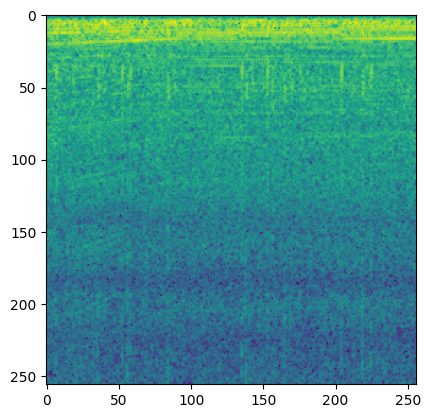

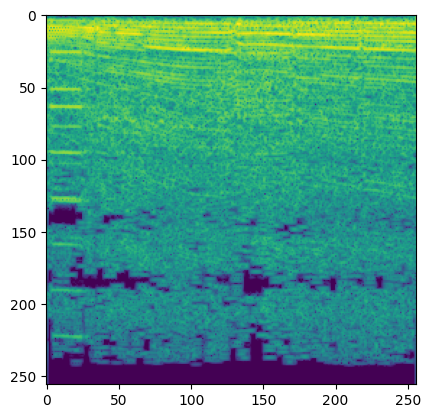

In [103]:
print("WAV")
print(wav_data[0,0])
print(torch.max(wav_data[0,0]))
print(torch.min(wav_data[0,0]))
print(" ")
print("MP3")
print(mp3_data[0,0])
print(torch.max(mp3_data[0,0]))
print(torch.min(mp3_data[0,0]))

plt.imshow(wav_data[0,0])
plt.show()
plt.imshow(mp3_data[0,0])


(257, 257)
(257, 257)


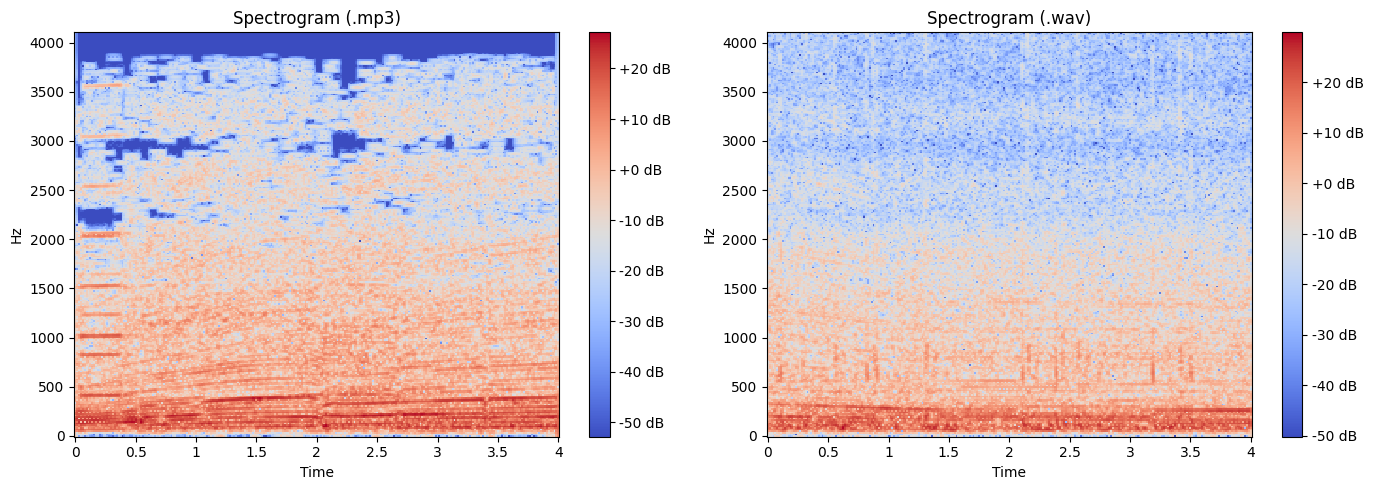

mp3_data.shape :  torch.Size([14, 1, 256, 256]) [[ -3.5569787 -11.908688  -34.49966   ... -12.512956    4.560421
    9.458163 ]
 [ -3.5713758 -17.540077  -13.463797  ... -14.356905    4.9589877
    9.935785 ]
 [ -1.3325362 -14.053988   -4.582567  ...  -0.4187678   8.455692
   11.739389 ]
 ...
 [-35.49489   -41.978996  -52.854126  ... -52.854126  -34.23306
  -27.850552 ]
 [-35.516132  -41.998295  -52.854126  ... -52.854126  -34.24974
  -27.86901  ]
 [-35.524765  -42.004555  -52.854126  ... -52.854126  -34.255867
  -27.87588  ]]
wav_data.shape :  torch.Size([14, 1, 256, 256]) [[-13.534102   -9.362779  -12.98004   ... -24.887152   -4.3919387
   -3.5296884]
 [ -7.1246524  -9.372793  -10.833809  ...  -8.433673   -4.875781
   -4.095627 ]
 [ -2.4261966  -9.653835  -10.727229  ...   3.956111    0.8938098
   -1.2497816]
 ...
 [-34.296432  -28.324524  -20.355299  ... -23.190208  -21.044283
  -21.50445  ]
 [-25.107086  -22.29475   -17.991543  ... -41.377472  -24.095795
  -21.685972 ]
 [-21.266623

In [104]:
# Using librosa.amplitude_to_db()
import matplotlib.pyplot as plt
import librosa.display

# Choose the first .wav and .mp3 file
wav_stft = globals()["wav_0000"]
mp3_stft = globals()["mp3_0000"]

# Convert amplitude to dB
wav_stft_db = librosa.amplitude_to_db(wav_stft)
mp3_stft_db = librosa.amplitude_to_db(mp3_stft)

print(wav_stft_db.shape)
print(mp3_stft_db.shape)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 2)
librosa.display.specshow(wav_stft_db, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (.wav)')
plt.subplot(1, 2, 1)
librosa.display.specshow(mp3_stft_db, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (.mp3)')
plt.tight_layout()
plt.show()

print("mp3_data.shape : ",mp3_data.shape, mp3_stft_db)
print("wav_data.shape : ",wav_data.shape, wav_stft_db)


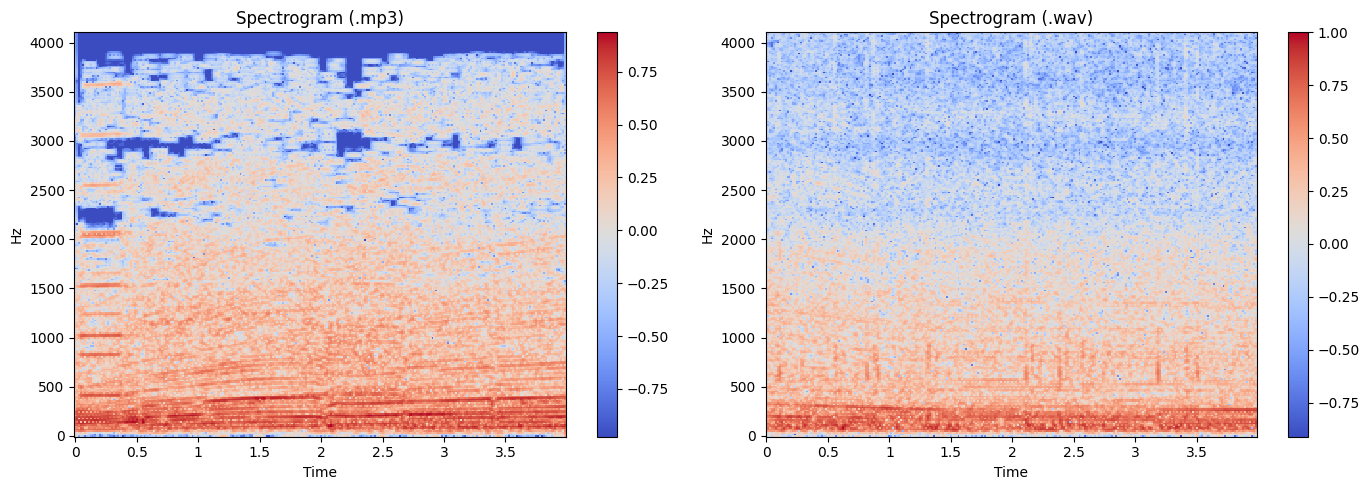

torch.Size([14, 1, 256, 256])
tensor([[[-0.0362,  0.0634, -0.0230,  ..., -0.7517, -0.3075,  0.1822],
         [ 0.1169,  0.0632,  0.0283,  ...,  0.0953,  0.0856,  0.1706],
         [ 0.2291,  0.0565,  0.0308,  ...,  0.2452,  0.3816,  0.3084],
         ...,
         [-0.2720, -0.1481, -0.0884,  ..., -0.2228, -0.4311, -0.3590],
         [-0.5323, -0.3896, -0.1992,  ..., -0.2852, -0.2669, -0.2157],
         [-0.3127, -0.2455, -0.1427,  ..., -0.3256, -0.7014, -0.2886]]])
The value at row 10, column 10 is: 0.7427151203155518


In [105]:
#Without liborsa.amplitude_to_db()
# Choose the first .wav and .mp3 file
wav_stft = wav_data[0,0].cpu().numpy()
mp3_stft = mp3_data[0,0].cpu().numpy()

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 2)
librosa.display.specshow(wav_stft, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar()
plt.title('Spectrogram (.wav)')
plt.subplot(1, 2, 1)
librosa.display.specshow(mp3_stft, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar()
plt.title('Spectrogram (.mp3)')
plt.tight_layout()
plt.show()

# Print the entire array
print(wav_data.shape)
print(wav_data[0])  # assuming the first element corresponds to "wav_0000"

# Print a specific pixel value
row = 10
col = 10
print(f"The value at row {row}, column {col} is: {wav_data[0][0][row, col]}")  # 0 for the first dimension (batch), 0 for the second dimension (channel)



In [128]:
import torch
from torch import nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.enabled = False  # cudnn 비활성화

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 1, kernel_size=3, stride=1, padding=1),  # 256x256 크기 이미지 생성
            nn.Tanh(),
        )

    def forward(self, x):
        #print("Generator Input : ", x.shape)
        x = self.model(x)
        #print("Generator Output : ", x.shape)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 64, kernel_size=4, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(16384, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

# Wasserstein GAN with Gradient Penalty (WGAN-GP) Loss
class WGAN_GP_Loss(nn.Module):
    def __init__(self, lambda_gp=10):
        super(WGAN_GP_Loss, self).__init__()
        self.lambda_gp = lambda_gp

    def forward(self, real_scores, fake_scores, real_images, generated_images):
        # Wasserstein GAN Loss
        generator_loss = -torch.mean(fake_scores)
        discriminator_loss = torch.mean(fake_scores) - torch.mean(real_scores)

        # Gradient Penalty
        alpha = torch.rand(real_images.size(0), 1, 1, 1).to(device)
        interpolates = alpha * real_images + (1 - alpha) * generated_images
        interpolates.requires_grad_(True)
        disc_interpolates = discriminator(interpolates)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.lambda_gp

        discriminator_loss += gradient_penalty

        return generator_loss, discriminator_loss

# Initialize the generator and the discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
wgan_gp_loss = WGAN_GP_Loss()



In [129]:
# Hyperparameters
batch_size = 1
discriminator_loss = 1e-5
generator_loss = 5e-6
num_epochs = 5
gradient_penalty_constant = 1
discriminator_updates_per_generator_update = 1

# Create PyTorch data loaders
mp3_loader = torch.utils.data.DataLoader(mp3_dataset, batch_size=batch_size, shuffle=False)
wav_loader = torch.utils.data.DataLoader(wav_dataset, batch_size=batch_size, shuffle=False)

# Loss function
wgan_gp_loss = WGAN_GP_Loss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=discriminator_loss)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=generator_loss)

for epoch in range(num_epochs):
    for i, (mp3, wav) in enumerate(zip(mp3_loader, wav_loader)):
        # Move the data to the chosen device
        mp3, wav = mp3[0].to(device), wav[0].to(device)

        # Discriminator updates
        for _ in range(discriminator_updates_per_generator_update):
            # Create the labels for the real and the fake data
            real_labels = torch.ones((mp3.size(0), 1)).to(device)
            fake_labels = torch.zeros((mp3.size(0), 1)).to(device)

            # Train the discriminator with real data
            outputs_real = discriminator(wav)
            d_loss_real = -torch.mean(outputs_real)

            # Train the discriminator with fake data
            fake_images = generator(mp3)
            outputs_fake = discriminator(fake_images)
            d_loss_fake = torch.mean(outputs_fake)

            # Compute the gradient penalty
            alpha = torch.rand(mp3.size(0), 1, 1, 1).to(device)
            interpolates = alpha * wav + (1 - alpha) * fake_images
            interpolates.requires_grad_(True)
            disc_interpolates = discriminator(interpolates)
            gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                            grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                            create_graph=True, retain_graph=True, only_inputs=True)[0]
            gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            d_loss = d_loss_real + d_loss_fake + gradient_penalty_constant * gradient_penalty

            discriminator.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Generator updates
        fake_images = generator(mp3)
        outputs = discriminator(fake_images)
        g_loss = -torch.mean(outputs)

        generator.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.6f}, g_loss: {g_loss.item():.6f}')


Epoch [1/5], d_loss: 1.078326, g_loss: -0.484254
Epoch [2/5], d_loss: 0.901302, g_loss: -0.334235
Epoch [3/5], d_loss: 0.728357, g_loss: -0.238312
Epoch [4/5], d_loss: 0.534595, g_loss: -0.194961
Epoch [5/5], d_loss: 0.848049, g_loss: -0.404077


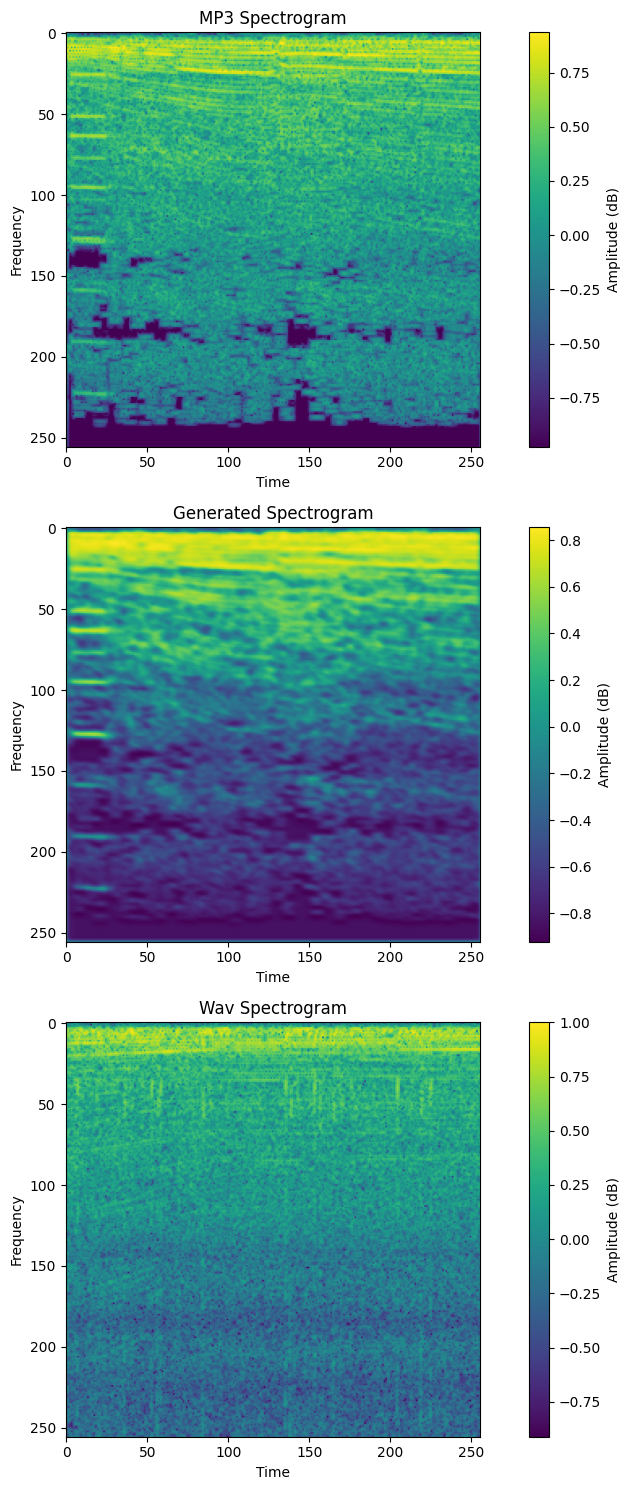

In [130]:
import matplotlib.pyplot as plt

# Convert the first mp3 data to numpy array
mp3_data_np = mp3_data[0, 0].cpu().numpy()

# Generate data using the generator
generated_wav = generator(mp3_data[0,0].unsqueeze(0).to(device))
generated_wav_np = generated_wav.detach().cpu().squeeze().numpy()

# Convert the first wav data to numpy array
wav_data_np = wav_data[0, 0].cpu().numpy()

# Create the figure
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot the first mp3 data (spectrogram) as an image
im1 = axs[0].imshow(mp3_data_np)
axs[0].set_title('MP3 Spectrogram')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')
fig.colorbar(im1, ax=axs[0], label='Amplitude (dB)')

# Plot the generated spectrogram
im2 = axs[1].imshow(generated_wav_np)
axs[1].set_title('Generated Spectrogram')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')
fig.colorbar(im2, ax=axs[1], label='Amplitude (dB)')

# Plot the first wav data (spectrogram) as an image
im3 = axs[2].imshow(wav_data_np)
axs[2].set_title('Wav Spectrogram')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')
fig.colorbar(im3, ax=axs[2], label='Amplitude (dB)')

plt.tight_layout()
plt.show()


In [131]:
print("Mp3","Max : ",np.max(mp3_data_np), "Min : ",np.min(mp3_data_np))
print(mp3_data_np)
print(" ")
print("Wav", "Max : ",np.max(wav_data_np), "Min : ",np.min(wav_data_np))
print(wav_data_np)
print(" ")
print("Generated", "Max : ",np.max(generated_wav_np), "Min : ", np.min(generated_wav_np))
print(generated_wav_np)

Mp3 Max :  0.9356035 Min :  -0.9756092
[[ 0.20210743  0.00258386 -0.5371181  ...  0.14118445 -0.0118522
   0.3960334 ]
 [ 0.20176351 -0.13195097 -0.03456801 ... -0.0031985  -0.05590445
   0.40555525]
 [ 0.25524974 -0.04866779  0.17760599 ...  0.20085835  0.27707982
   0.4890921 ]
 ...
 [-0.5599614  -0.7150263  -0.9756092  ... -0.9756092  -0.9756092
  -0.5301442 ]
 [-0.56089425 -0.7158006  -0.9756092  ... -0.9756092  -0.9756092
  -0.53074896]
 [-0.5614017  -0.7162616  -0.9756092  ... -0.9756092  -0.9756092
  -0.5311475 ]]
 
Wav Max :  1.0 Min :  -0.9112126
[[-0.03624761  0.06340599 -0.02301097 ... -0.75170636 -0.30747372
   0.18216014]
 [ 0.11687517  0.06316674  0.02826285 ...  0.09532118  0.0856024
   0.17060101]
 [ 0.22912204  0.05645263  0.03080904 ...  0.24521399  0.38159633
   0.30843747]
 ...
 [-0.27204382 -0.14806229 -0.08839494 ... -0.2227562  -0.4311493
  -0.35899305]
 [-0.5322629  -0.38959306 -0.19920713 ... -0.2852491  -0.2669335
  -0.21566695]
 [-0.312728   -0.24554086 -0.14